<a href="https://colab.research.google.com/github/duanzhihua/-transformer-english2chinese-/blob/main/%E2%80%9CLangGraph_%E7%AF%87_%E5%A4%9A%E8%AA%9E%E8%A8%80%E7%BF%BB%E8%AD%AF_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🥱 LangGraph 篇_多語言翻譯

❤️ Created by [hengshiousheu](https://huggingface.co/Heng666).

# 環境建置

## 安裝套件包

在本演練中，

我們將使用以下套件：

In [1]:
%pip install --upgrade --quiet langchain
%pip install --upgrade --quiet langchain-openai
%pip install --upgrade --quiet langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 3.5 MB/s eta 0:00:00


我們需要設置 環境變數 `OPENAI_API_KEY` ，可以直接完成，如下所示：

In [2]:
import os
import getpass
# from google.colab import userdata

# os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

### (可用可不用)LangSmith

你用LangChain構建的許多應用程式將包含多個步驟，並多次調用LLM調用。隨著這些應用程式變得越來越複雜，能夠檢查您的鏈或代理內部到底發生了什麼變得至關重要。最好的方法是與[LangSmith](https://smith.langchain.com)合作。

請注意，LangSmith 不是必需的，但它很有説明。如果您確實想使用 LangSmith，請在上面的鏈接中註冊后，請確保設置環境變數以開始記錄跟蹤：

In [4]:
import os
import getpass
from datetime import datetime
import pytz

current_time = datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d %Z")

os.environ["LANGCHAIN_TRACING_V2"] = "false" ##想要使用記得改 true, 不要時改 false.
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = f"LangGraph 多語言翻譯-{current_time}"
# os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

# 開始英文翻譯 Agent 設計

## 建立 LLM

In [5]:
from langchain_openai import ChatOpenAI

# # 創建LLM實例
# llm = ChatOpenAI(
#     # model_name="gpt-4",  # 修改模型版本
#     temperature=0.7,     # 調整溫度
#     max_tokens=1024      # 設定最大輸出 token 量
# )

llm = ChatOpenAI(
                api_key="4fe1c517330b5a43a3218b241d399941.ZOi1tkW3TrSy1I3O",
                base_url="https://open.bigmodel.cn/api/paas/v4/",
                model="glm-4-flash",
                # model="glm-4-plus",
            )

## 建立狀態

In [6]:
from pydantic import Field
from langchain_core.pydantic_v1 import BaseModel

# 使用 Pydantic 定義狀態
class TranslationState(BaseModel):
    input_text: str = Field(description="待翻譯的文本")
    translated_text: str = Field(default="", description="翻譯後的文本")

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


## 建立節點

In [8]:
def translateNode(state: TranslationState) -> TranslationState:
    # llm = ChatOpenAI()
    llm = ChatOpenAI(
                api_key="4fe1c517330b5a43a3218b241d399941.ZOi1tkW3TrSy1I3O",
                base_url="https://open.bigmodel.cn/api/paas/v4/",
                model="glm-4-flash",
                # model="glm-4-plus",
            )
    response = llm.invoke(f"請將以下文本翻譯成英文：{state.input_text}")
    state.translated_text = response.content
    return state

## 建立圖，並連接節點與邊

In [9]:
from langgraph.graph import Graph, END

# 創建圖
workflow = Graph()

# 添加翻譯節點
workflow.add_node("translate", translateNode)

# 設置入口點
workflow.set_entry_point("translate")
# 設置 End point
workflow.add_edge("translate", END)

# 編譯圖
app = workflow.compile()

## 可視化當前節點

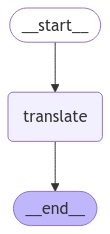

In [10]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## 開始與圖對話

In [11]:
initial_state: TranslationState = TranslationState(
    input_text="你好，今天天氣真好。",
)

result = app.invoke(initial_state, debug=False)

In [12]:
print(f"原文：{initial_state.input_text}")
print(f"譯文：{result.translated_text}")

原文：你好，今天天氣真好。
譯文：Hello, the weather is really nice today.


## 延伸題目

為確保學員能夠靈活運用 LangGraph ，我們放了兩道題目在底下提供學員自主練習

### 題目ㄧ、提升翻譯品質（基礎）
問題：如何修改 translateNode 函數中的提示，以提高翻譯品質？請在下方空白處填寫您的改進建議。

In [13]:
def translateNode(state: TranslationState) -> TranslationState:
    # llm = ChatOpenAI()
    llm = ChatOpenAI(
                api_key="4fe1c517330b5a43a3218b241d399941.ZOi1tkW3TrSy1I3O",
                base_url="https://open.bigmodel.cn/api/paas/v4/",
                model="glm-4-flash",
                # model="glm-4-plus",
            )
    response = llm.invoke(f"___________________________________")
    state.translated_text = response.content
    return state

小提示：修改提示可以顯著影響翻譯質量。考慮添加更多上下文、指定翻譯風格或要求更準確的術語使用等。這是一個簡單但有效的改進方法。

#### 題目一、參考答案

In [14]:
def translateNode(state: TranslationState) -> TranslationState:
    # llm = ChatOpenAI()
    llm = ChatOpenAI(
                api_key="4fe1c517330b5a43a3218b241d399941.ZOi1tkW3TrSy1I3O",
                base_url="https://open.bigmodel.cn/api/paas/v4/",
                model="glm-4-flash",
                # model="glm-4-plus",
            )
    response = llm.invoke(f"請將以下文本精確地翻譯成英文,保持原文的語氣和風格,並確保專業術語的準確性。如果有任何文化特定的表達,請提供適當的英語等效表達：\n\n{state.input_text}")
    state.translated_text = response.content
    return state

我們在提示中加入了更具體的指示,如「精確地翻譯」、「保持原文的語氣和風格」。
要求確保專業術語的準確性,這對於某些領域的翻譯尤其重要。
提到了處理文化特定表達的方法,這有助於產生更自然的翻譯。

### 題目二、添加語言選擇

問題：如何修改 TranslationState 類和 translateNode 函數，使其支持將文本翻譯成多種目標語言？請填寫下面的代碼：

In [16]:
class TranslationState(BaseModel):
    input_text: str = Field(description="待翻譯的文本")
    translated_text: str = Field(default="", description="翻譯後的文本")


def translateNode(state: TranslationState) -> TranslationState:
    # llm = ChatOpenAI()
    llm = ChatOpenAI(
                api_key="4fe1c517330b5a43a3218b241d399941.ZOi1tkW3TrSy1I3O",
                base_url="https://open.bigmodel.cn/api/paas/v4/",
                model="glm-4-flash",
                # model="glm-4-plus",
            )
    response = llm.invoke(f"___________________________________")
    state.translated_text = response.content
    return state

小提示：反思：添加語言選擇增加了應用的靈活性。這需要修改狀態模型和翻譯節點，但不需要更改整體工作流程結構。這是一個中等難度的改進，能顯著提升應用的實用性。

#### 題目二、參考答案

In [17]:
class TranslationState(BaseModel):
    input_text: str = Field(description="待翻譯的文本")
    translated_text: str = Field(default="", description="翻譯後的文本")
    target_language: str = Field(description="目標翻譯語言")

def translateNode(state: TranslationState) -> TranslationState:
    llm = ChatOpenAI()
    response = llm.invoke(f"請將以下文本精確地翻譯成{state.target_language},保持原文的語氣和風格,並確保專業術語的準確性。如果有任何文化特定的表達,請提供適當的{state.target_language}等效表達：\n\n{state.input_text}")
    state.translated_text = response.content
    return state

說明：
1. TranslationState 的修改：
  - 添加了 target_language 字段,用於指定目標翻譯語言。
  - 使用 Field 為新字段添加了描述,提高代碼的可讀性和自文檔化程度。
2. translateNode 函數的改進：
  - 在提示中使用了 state.target_language,使翻譯目標語言可配置。
  - 保留了之前改進的提示內容,確保翻譯質量。

# 設計多語言翻譯 Agent

## 建立 LLM

In [18]:
from langchain_openai import ChatOpenAI

# 創建LLM實例
# llm = ChatOpenAI(
#     # model_name="gpt-4",  # 修改模型版本
#     temperature=0.7,     # 調整溫度
#     max_tokens=1024      # 設定最大輸出 token 量
# )

llm = ChatOpenAI(
                api_key="4fe1c517330b5a43a3218b241d399941.ZOi1tkW3TrSy1I3O",
                base_url="https://open.bigmodel.cn/api/paas/v4/",
                model="glm-4-flash",
                # model="glm-4-plus",
            )

## 建立狀態

In [19]:
from pydantic import Field
from langchain_core.pydantic_v1 import BaseModel

# 使用 Pydantic 定義狀態
class TranslationState(BaseModel):
    input_intent: str = Field(description="文本中意圖")
    input_text: str = Field(description="待翻譯的文本")
    input_text_lang_code: str = Field(description="待翻譯的文本語言代碼")
    translated_text: str = Field(default="", description="翻譯後的文本")
    translated_text_lang_code: str = Field(description="翻譯後的文本語言代碼")

## 建立節點

In [25]:
from langchain_core.messages import HumanMessage, AIMessage

# 辨識語系
def detectLangCodeNode(state: TranslationState) -> TranslationState:
    response: AIMessage = llm.invoke([HumanMessage(content=f"輸入文字：\n{state.input_text}\n請返回該文字的語系代碼（例如：zh_Hant）。\n\n範例：\n輸入文字：天氣真好\n返回語系代碼：zh_Hant\n\n輸入文字：The weather is nice\n返回語系代碼：en\n\n輸入文字：天気がいいです\n返回語系代碼：ja\n\n輸入文字：날씨가 좋다\n返回語系代碼：ko")])
    state.input_text_lang_code = response.content.strip()
    return state

# 偵測意圖，重新理解語意
def detectIntentNode(state: TranslationState) -> TranslationState:
    # 此函數用來進一步分析語句的意圖
    response: AIMessage = llm.invoke([HumanMessage(content=f"請分析這句話的意圖：\n{state.input_text}")])
    state.input_intent = response.content.strip()  # 儲存語意分析結果
    return state

# 英文翻譯
def translateENNode(state: TranslationState) -> TranslationState:
    response = llm.invoke(f"請將以下文本並且根據意圖成翻譯成英文，只需要翻譯後文本就好。\n文本：\n{state.input_text}，意圖：\n{state.input_intent}，翻譯結果：\n")
    state.translated_text = response.content.strip()
    return state

# 日文翻譯
def translateJPNode(state: TranslationState) -> TranslationState:
    # llm = ChatOpenAI()
    llm = ChatOpenAI(
                api_key="4fe1c517330b5a43a3218b241d399941.ZOi1tkW3TrSy1I3O",
                base_url="https://open.bigmodel.cn/api/paas/v4/",
                model="glm-4-flash",
                # model="glm-4-plus",
            )
    response = llm.invoke(f"請將以下文本並且根據意圖成翻譯成日文，只需要翻譯後文本就好。\n文本：\n{state.input_text}，意圖：\n{state.input_intent}，翻譯結果：\n")
    state.translated_text = response.content
    return state


## 加入選項

In [26]:
# 判斷要翻譯的語系，而選擇不同 Node
def selectLangCode(state: TranslationState) -> TranslationState:
    if state.translated_text_lang_code == "jp":
        return "jp"
    elif state.translated_text_lang_code == "en":
        return "en"
    else:
        return "end"

## 建立圖，並連接節點與邊

In [27]:
import os
from langgraph.graph import START, END, Graph

# 創建圖
multilingualworkflow = Graph()

# 添加節點
multilingualworkflow.add_node("detectLangCode", detectLangCodeNode)
multilingualworkflow.add_node("detectIntent", detectIntentNode)
multilingualworkflow.add_node("translateEN", translateENNode)
multilingualworkflow.add_node("translateJP", translateJPNode)

# 設置入口點
multilingualworkflow.set_entry_point("detectLangCode")

# 定義邊
multilingualworkflow.add_edge("detectLangCode", "detectIntent")
multilingualworkflow.add_edge("translateEN", END)
multilingualworkflow.add_edge("translateJP", END)

# 添加選項
multilingualworkflow.add_conditional_edges(
    "detectIntent",
    selectLangCode,
    {
        "en": "translateEN",
        "jp": "translateJP",
        "end": END
    }
  )

# 編譯圖
multilingualapp = multilingualworkflow.compile()


## 可視化當前節點

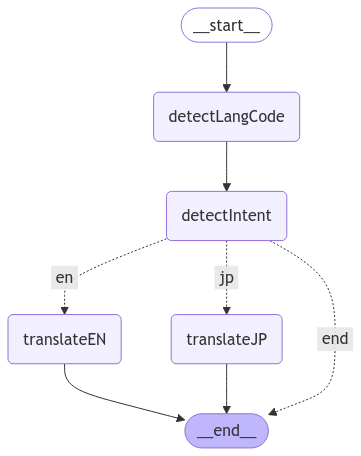

In [28]:
from IPython.display import Image, display

display(Image(multilingualapp.get_graph(xray=True).draw_mermaid_png()))

## 開始與圖對話

### 中文翻譯日文

In [29]:
initial_state: TranslationState = TranslationState(
    input_text="今天天氣如何？",
    translated_text_lang_code="jp"
)

result = multilingualapp.invoke(initial_state, debug=False)

In [30]:
print(result)

input_intent='這句話的意圖通常是詢問當天的天氣狀況。在交流中，這種問法可能出於以下幾種情境：\n\n1. **好奇心**：對當天的天氣有興趣，想知道是晴是雨，以便安排自己的活動。\n2. **實用性**：基於實用目的，比如決定是否帶雨具、是否需要穿暖一點或是是否適合外出。\n3. **社交**：作為日常談話的一部分，用來開啟話題或是與人建立關係。\n4. **助人**：可能是在他人面前提出這個問題，表示關心對方的天氣狀況，或是在請求他人提供天氣資訊。\n\n總的來說，這句話的意圖是獲取當地的天氣信息。' input_text='今天天氣如何？' input_text_lang_code='輸入文字：今天天氣如何？\n返回語系代碼：zh_Hant' translated_text='今日の天気はどうですか？' translated_text_lang_code='jp'


In [31]:
print(f"原文：{result.input_text}")
print(f"譯文：{result.translated_text}")

原文：今天天氣如何？
譯文：今日の天気はどうですか？


### 中文翻譯英文

In [32]:
initial_state: TranslationState = TranslationState(
    input_text="今天天氣如何？",
    translated_text_lang_code="en"
)

result = multilingualapp.invoke(initial_state, debug=False)

In [33]:
print(f"原文：{result.input_text}")
print(f"譯文：{result.translated_text}")

原文：今天天氣如何？
譯文：How is the weather today?


### 英文翻譯日文

In [34]:
initial_state: TranslationState = TranslationState(
    input_text="How to go to Taipei Main Station",
    translated_text_lang_code="jp"
)

result = multilingualapp.invoke(initial_state, debug=False)

In [35]:
print(f"原文：{result.input_text}")
print(f"譯文：{result.translated_text}")

原文：How to go to Taipei Main Station
譯文：台北車站への行き方


## 反思與延伸作業
恭喜你完成了這個使用 LangGraph 和 LLM 處理多語言翻譯的實踐！現在讓我們進行一些反思，並探索如何進一步應用和擴展你所學到的知識。



### 反思問題

1. 比較 LangGraph 與您之前使用過的其他工作流程工具或框架，它們有哪些異同？LangGraph 在處理語言相關任務時有哪些優勢？

2. 我們的翻譯應用目前是如何處理錯誤的？您認為還有哪些可能的錯誤情況沒有被考慮到？如何進一步改進錯誤處理機制？

3. 從用戶體驗的角度來看，您認為當前的翻譯應用還有哪些可以改進的地方？

### 回家作業

1. 擴展功能：嘗試在翻譯應用中添加一個新的節點，實現文本摘要功能。這個節點應該能夠接收原文和翻譯後的文本，然後生成這兩種語言的摘要。思考這個新功能如何融入現有的工作流程。

2. 領域特化：選擇一個特定領域（如醫療、法律或技術文檔），並思考如何調整當前的翻譯應用以更好地處理該領域的專業術語和特殊要求。提出具體的改進建議和實施步驟。

3. 用戶界面設計：假設您要為這個翻譯應用開發一個基於 Web 的用戶界面。繪製一個簡單的線框圖，說明用戶如何輸入文本、選擇語言、查看翻譯結果等。考慮如何在界面中展示批量翻譯的進度和結果。

4. 創新應用：基於您對 LangGraph 的理解，構思一個全新的、創新的語言處理應用。它可以是一個多步驟的文本分析工具、一個智能寫作助手，或者任何您認為有趣且有用的應用。描述這個應用的主要功能和工作流程，並解釋為什麼 LangGraph 適合用來實現它。

完成這些反思和作業將幫助您更深入地理解 LangGraph 的工作原理和應用潛力，同時也能激發您在實際項目中的創新思維。祝您學習愉快！